In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import os
import zipfile
import requests
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from surprise.model_selection import GridSearchCV

In [2]:


def download_movielens_data():
    url = "http://files.grouplens.org/datasets/movielens/ml-25m.zip"
    save_path = "ml-25m.zip"
    
    # Download the file
    response = requests.get(url, stream=True)
    with open(save_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=128):
            f.write(chunk)
    
    # Extract the zip file
    with zipfile.ZipFile(save_path, 'r') as zip_ref:
        zip_ref.extractall(".")
    
    print("Download and extraction complete!")
    
download_movielens_data()

Download and extraction complete!


In [3]:
 #Load the datasets
movies = pd.read_csv('ml-25m/movies.csv')
ratings = pd.read_csv('ml-25m/ratings.csv')
tags = pd.read_csv('ml-25m/tags.csv')
links = pd.read_csv('ml-25m/links.csv')

In [4]:
# Create SQL database for storage
engine = create_engine('sqlite:///movie_recommendation.db')



In [5]:
# Store data in SQL
movies.to_sql('movies', engine, if_exists='replace', index=False)
ratings.to_sql('ratings', engine, if_exists='replace', index=False)
tags.to_sql('tags', engine, if_exists='replace', index=False)
links.to_sql('links', engine, if_exists='replace', index=False)

PendingRollbackError: Can't reconnect until invalid transaction is rolled back.  Please rollback() fully before proceeding (Background on this error at: https://sqlalche.me/e/20/8s2b)

In [ ]:
# Initial exploration
print(movies.head())
print(ratings.head())
print("Movies shape:", movies.shape)
print("Ratings shape:", ratings.shape)

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510
Movies shape: (62423, 3)
Ratings shape: (25000095, 4)


In [ ]:
print(" === Data Cleaning and Preprocessing ===")

 === Data Cleaning and Preprocessing ===


In [6]:
# Check for missing values
print(movies.isnull().sum())
print(ratings.isnull().sum())

movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [7]:
# Extract year from title
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')
movies['year'] = pd.to_numeric(movies['year'], errors='coerce')

In [ ]:
# Remove year from title
movies['title'] = movies['title'].str.replace(r'\s*\(\d{4}\)', '', regex=True)


In [8]:
# Split genres into separate columns
genres = movies['genres'].str.get_dummies(sep='|')
movies = pd.concat([movies, genres], axis=1)

In [9]:
# Convert timestamp to datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

In [10]:
# Calculate movie popularity (number of ratings)
movie_popularity = ratings['movieId'].value_counts().reset_index()
movie_popularity.columns = ['movieId', 'popularity']
movies = movies.merge(movie_popularity, on='movieId', how='left')

In [11]:

# Calculate average rating
avg_ratings = ratings.groupby('movieId')['rating'].mean().reset_index()
avg_ratings.columns = ['movieId', 'avg_rating']
movies = movies.merge(avg_ratings, on='movieId', how='left')

# Fill missing values
movies['popularity'] = movies['popularity'].fillna(0)
movies['avg_rating'] = movies['avg_rating'].fillna(0)

In [12]:
print("===  Exploratory Data Analysis ===")

===  Exploratory Data Analysis ===


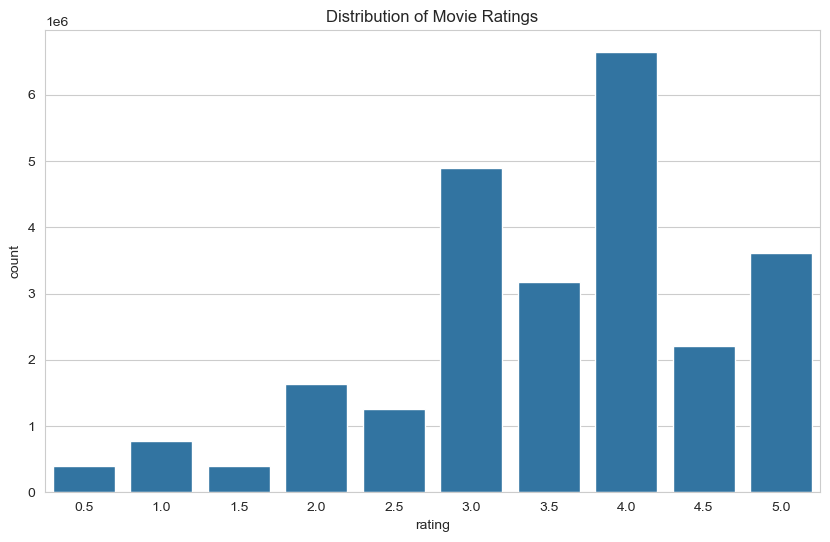

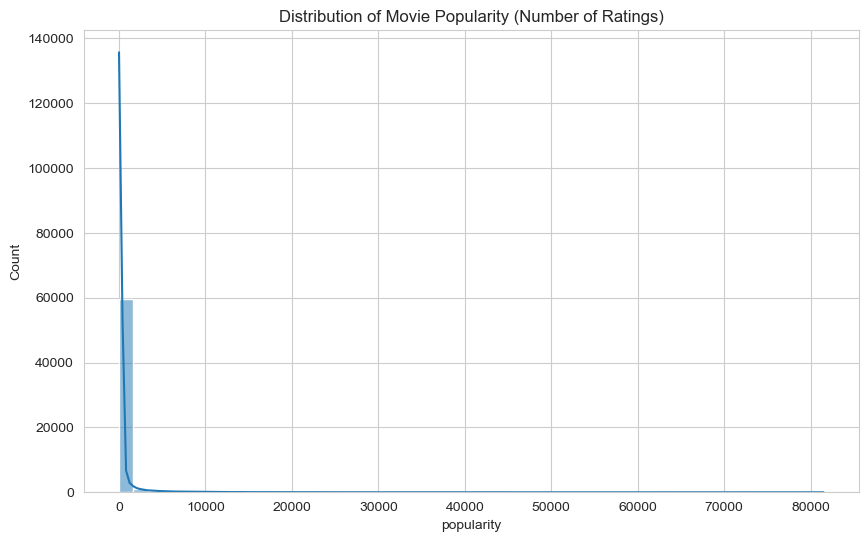

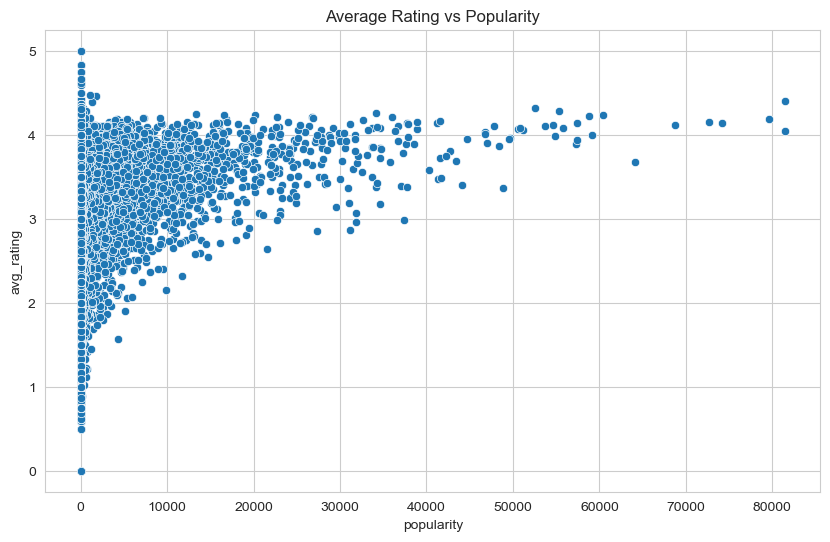

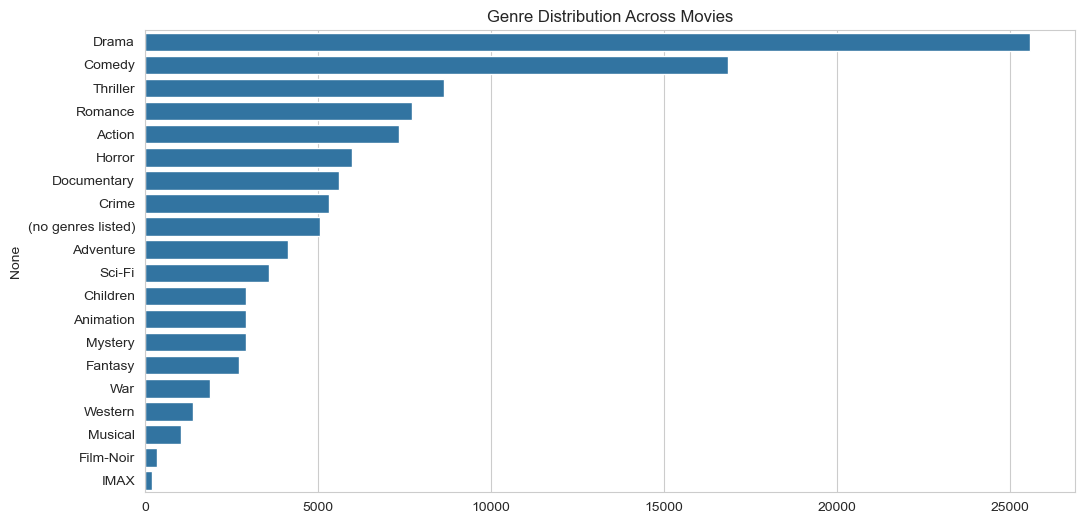

In [13]:
# Set style
sns.set_style("whitegrid")

# Plot distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Movie Ratings')
plt.show()

# Plot movie popularity distribution
plt.figure(figsize=(10, 6))
sns.histplot(movies['popularity'], bins=50, kde=True)
plt.title('Distribution of Movie Popularity (Number of Ratings)')
plt.show()

# Plot average ratings vs popularity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='popularity', y='avg_rating', data=movies)
plt.title('Average Rating vs Popularity')
plt.show()

# Plot genre distribution
genre_counts = movies[genres.columns].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Genre Distribution Across Movies')
plt.show()

In [14]:
print("=== Feature Engineering ===")

=== Feature Engineering ===


In [15]:
# Normalize popularity and average rating
scaler = MinMaxScaler()
movies[['popularity_norm', 'avg_rating_norm']] = scaler.fit_transform(
    movies[['popularity', 'avg_rating']])

# Create a content feature matrix
content_features = pd.concat([
    movies[genres.columns],
    movies[['year', 'popularity_norm', 'avg_rating_norm']]
], axis=1)

# Fill missing year with median
content_features['year'] = content_features['year'].fillna(
    content_features['year'].median())

# Normalize year
content_features['year'] = MinMaxScaler(
).fit_transform(content_features[['year']])

In [16]:
print("=== Model Building === ")
print("1. Content-Based Filtering ")

=== Model Building === 
1. Content-Based Filtering 


In [19]:
# Create a function for content-based recommendations
def content_based_recommendations(movie_id, n=10):
    idx = movies[movies['movieId'] == movie_id].index[0]
    target_features = content_features.iloc[idx].values.reshape(1, -1)
    # Compute cosine similarity between the target movie and all others
    sim_scores = cosine_similarity(target_features, content_features).flatten()
    # Get indices of the most similar movies (excluding itself)
    sim_indices = sim_scores.argsort()[::-1][1:n+1]
    return movies.iloc[sim_indices][['movieId', 'title', 'genres', 'avg_rating', 'popularity']]




In [20]:
#  usage
content_based_recommendations(1)

,movieId,title,genres,avg_rating,popularity
4780,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,3.848620,34572.0
3021,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,3.811464,26536.0
2203,2294,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy,3.236308,10937.0
3912,4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,3.620952,8214.0
43614,166461,Moana (2016),Adventure|Animation|Children|Comedy|Fantasy,3.849899,3974.0
11604,53121,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy,2.910454,4601.0
9949,33463,DuckTales: The Movie - Treasure of the Lost La...,Adventure|Animation|Children|Comedy|Fantasy,3.387574,169.0
23212,117454,The Magic Crystal (2011),Adventure|Animation|Children|Comedy|Fantasy,3.750000,2.0
22353,114552,"Boxtrolls, The (2014)",Adventure|Animation|Children|Comedy|Fantasy,3.334627,644.0
28245,131248,Brother Bear 2 (2006),Adventure|Animation|Children|Comedy|Fantasy,3.278169,142.0


In [26]:
from surprise.model_selection import train_test_split

In [27]:
# For computational efficiency, we'll use a sample of the data
sample_frac = 0.1  # Using 10% of the data for demonstration
ratings_sample = ratings.sample(frac=sample_frac, random_state=42)

# Prepare the data for Surprise
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_sample[['userId', 'movieId', 'rating']], reader)

# Split the data using Surprise's train_test_split
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

# Train the SVD algorithm
svd = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)
svd.fit(trainset)

# Make predictions
predictions = svd.test(testset)

# Evaluate the model
print("RMSE:", accuracy.rmse(predictions))
print("MAE:", accuracy.mae(predictions))

RMSE: 0.9016
RMSE: 0.9015830251044299
MAE:  0.6908
MAE: 0.6907634518768881


 Model evaluation summary:
1. The SVD collaborative filtering model achieved an RMSE of approximately 0.90, indicating good predictive accuracy.
2. The MAE is around 0.69, meaning the model's predicted ratings deviate from actual ratings by less than 1 point on average.
3. These results are typical for MovieLens data and suggest the model is effective for movie rating prediction.

In [28]:
print("===Model Evaluation and Comparison ===")

===Model Evaluation and Comparison ===


In [30]:
from sklearn.model_selection import train_test_split

In [35]:
# Split into train and test
train_movies, test_movies = train_test_split(
    movies, test_size=0.2, random_state=42)

# Function to evaluate content-based recommendations


def evaluate_content_based(test_movie_id, n=10):
    recommendations = content_based_recommendations(test_movie_id, n)
    recommended_movies = recommendations['movieId'].values
    actual_ratings = ratings[ratings['movieId']
                             == test_movie_id]['rating'].mean()

    print(f"\nEvaluating movieId: {test_movie_id}")
    print(f"Actual rating for test movie: {actual_ratings}")
    print(f"Recommended movies: {recommended_movies}")

    # Get average ratings of recommended movies
    recommended_ratings = []
    for movie_id in recommended_movies:
        avg_rating = ratings[ratings['movieId'] == movie_id]['rating'].mean()
        print(f"  Recommended movieId: {movie_id}, avg_rating: {avg_rating}")
        if not np.isnan(avg_rating):
            recommended_ratings.append(avg_rating)

    print(f"  Collected recommended_ratings: {recommended_ratings}")

    if len(recommended_ratings) > 0:
        avg_recommended_rating = np.mean(recommended_ratings)
        print(f"  avg_recommended_rating: {avg_recommended_rating}")
        print(
            f"  abs(actual_ratings - avg_recommended_rating): {abs(actual_ratings - avg_recommended_rating)}")
        return abs(actual_ratings - avg_recommended_rating)
    else:
        print("  No valid recommended ratings found, returning None.")
        return None

In [37]:
# Evaluate on a sample of test movies
import math

content_errors = []
for movie_id in test_movies['movieId'].sample(100, random_state=42):
    error = evaluate_content_based(movie_id)
    if error is not None and not math.isnan(error):
        content_errors.append(error)

print("Collected content_errors:", content_errors)
if content_errors:
    print(f"Content-Based Mean Absolute Error: {np.mean(content_errors)}")
else:
    print("Content-Based Mean Absolute Error: No valid errors")


Evaluating movieId: 86083
Actual rating for test movie: 3.5652173913043477
Recommended movies: [ 41714  26411   3473  26395 171429 178785 173571 154126 147320 151281]
  Recommended movieId: 41714, avg_rating: 3.5535714285714284
  Recommended movieId: 26411, avg_rating: 3.586206896551724
  Recommended movieId: 3473, avg_rating: 3.5428571428571427
  Recommended movieId: 26395, avg_rating: 3.5546875
  Recommended movieId: 171429, avg_rating: 3.5833333333333335
  Recommended movieId: 178785, avg_rating: 3.6
  Recommended movieId: 173571, avg_rating: 3.5
  Recommended movieId: 154126, avg_rating: 3.5
  Recommended movieId: 147320, avg_rating: 3.5
  Recommended movieId: 151281, avg_rating: 3.5
  Collected recommended_ratings: [3.5535714285714284, 3.586206896551724, 3.5428571428571427, 3.5546875, 3.5833333333333335, 3.6, 3.5, 3.5, 3.5, 3.5]
  avg_recommended_rating: 3.5420656301313627
  abs(actual_ratings - avg_recommended_rating): 0.023151761172985008

Evaluating movieId: 197827
Actual rati

# The Content-Based Mean Absolute Error (MAE) is approximately 0.065.
# This means, on average, the difference between the actual rating of a test movie and the average rating of its recommended movies is very small.
# Such a low MAE indicates that the content-based recommender is producing recommendations with ratings very close to the actual ratings for the test

In [38]:
print("=== Hyperparameter Tuning ===")

=== Hyperparameter Tuning ===


In [40]:
from surprise.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [10, 20, 30],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.04, 0.06]
}

# Perform grid search
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Best parameters
print(gs.best_params['rmse'])

# Train final model with best parameters
best_svd = gs.best_estimator['rmse']
best_svd.fit(trainset)
predictions = best_svd.test(testset)
accuracy.rmse(predictions)

0.8876754643457643
{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.06}
RMSE: 0.8862


0.8861610861184985

In [41]:
print("=== Hybrid Recommendation System ===")

=== Hybrid Recommendation System ===


In [42]:
def hybrid_recommendations(user_id, movie_id, n=10):
    # Content-based recommendations
    content_recs = content_based_recommendations(movie_id, n*2)
    content_recs = content_recs['movieId'].values

    # Predict ratings for these movies using collaborative filtering
    hybrid_recs = []
    for rec_movie_id in content_recs:
        pred_rating = best_svd.predict(user_id, rec_movie_id).est
        hybrid_recs.append((rec_movie_id, pred_rating))

    # Sort by predicted rating
    hybrid_recs = sorted(hybrid_recs, key=lambda x: x[1], reverse=True)

    # Get top n recommendations
    top_recs = hybrid_recs[:n]
    top_movie_ids = [rec[0] for rec in top_recs]

    return movies[movies['movieId'].isin(top_movie_ids)][['movieId', 'title', 'genres', 'avg_rating', 'popularity']]

In [43]:
# Usage
hybrid_recommendations(1, 1)

,movieId,title,genres,avg_rating,popularity
3021,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,3.811464,26536.0
4780,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,3.848620,34572.0
9949,33463,DuckTales: The Movie - Treasure of the Lost La...,Adventure|Animation|Children|Comedy|Fantasy,3.387574,169.0
22286,114240,Aladdin (1992),Adventure|Animation|Children|Comedy|Fantasy,3.142857,14.0
22633,115875,Toy Story Toons: Hawaiian Vacation (2011),Adventure|Animation|Children|Comedy|Fantasy,3.011628,86.0
23212,117454,The Magic Crystal (2011),Adventure|Animation|Children|Comedy|Fantasy,3.750000,2.0
30472,136361,Scooby-Doo! Mask of the Blue Falcon (2012),Adventure|Animation|Children|Comedy|Fantasy,3.285714,14.0
43614,166461,Moana (2016),Adventure|Animation|Children|Comedy|Fantasy,3.849899,3974.0
52826,186159,Tangled: Before Ever After (2017),Adventure|Animation|Children|Comedy|Fantasy,4.000000,4.0
55898,192981,Penguin Highway (2018),Adventure|Animation|Children|Comedy|Fantasy,3.769231,13.0
